# Surface concentrations

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from datetime import date

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2015
results_folder1 = f'/data/brogalla/run_storage/Mn-reference-202103/ref-{year}-202103/'

In [3]:
stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])
stn_n = np.array(['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7',
                  'CAA8','CAA9', 'CB1','CB2','CB3','CB4'])

###### Load files:

In [8]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

In [9]:
ref   = nc.Dataset(f'{results_folder1}ANHA12_EXH006_{year}_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [10]:
results1  = nc.Dataset(f'{results_folder1}ANHA12_EXH006_{year}_monthly.nc')
dissolmn1 = np.array(results1.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn1 = np.array(results1.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units

In [11]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t

##### Functions:

In [14]:
def plot_layer(month, layer, variable, vmin=0,vmax=35, savefig=False):
    
    plot_var = np.mean(variable[month,3:17,:,:], axis=0)
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y = proj1(lons, lats)

    contour = proj1.contourf(x, y, plot_var, np.arange(vmin,vmax+1,1),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.72, 0.14, 0.04, 0.6])
    cbar    = fig.colorbar(contour, cax=cbar_ax, ticks=[0,2,4,6,8,10,12,14])
    cbar.set_label('Dissolved Mn [nM]', fontsize=8) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=8)
    
    figure = plt.gcf()
#     figure.set_size_inches(4.5*1.8, 3.7)
    figure.set_size_inches(4.5*2.8, 3.7*2)
    
    if savefig:
#         fig.savefig('/ocean/brogalla/GEOTRACES/figures/R5-surface-field-'+\
#                     str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight', dpi=300)
        figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R5-surface-fields-January.png', \
                       bbox_inches='tight', dpi=300)
        figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R5-surface-fields-January.svg', \
                       bbox_inches='tight', dpi=300, format='svg')
    
    return

In [13]:
def load_results(folder_ref):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,1,isize,jsize))   ; dmn_sed = np.empty((12,1,isize,jsize)); 
    dmn_atm = np.empty((12,1,isize,jsize))   ; dmn_ice = np.empty((12,1,isize,jsize));
    dmn_sedice = np.empty((12,1,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,0,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sed[i,0,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sedice[i,0,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_atm[i,0,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_ice[i,0,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]*(10**9)*(3600*24*31)
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]*(10**9)*(3600*24*31)
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

##### Figures of surface concentrations:

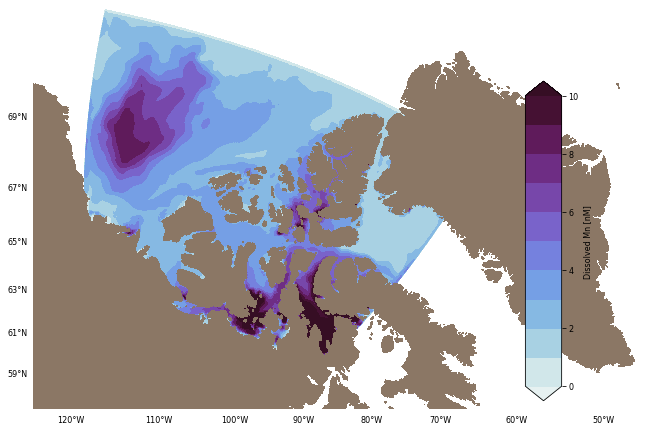

In [44]:
plot_layer(0,0,dissolmn1,vmin=0,vmax=10, savefig=False)

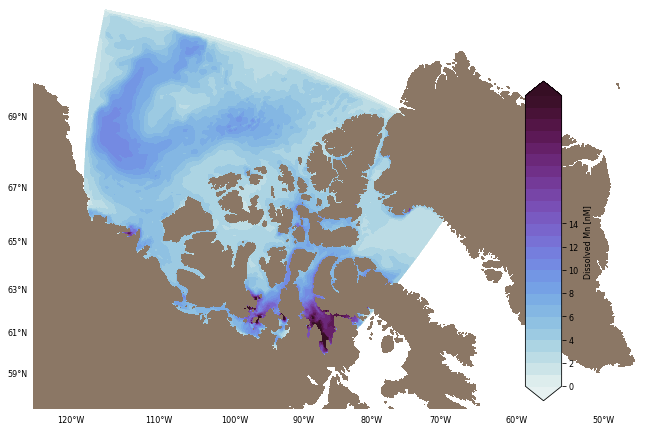

In [24]:
plot_layer(6,0,dissolmn1,vmin=0,vmax=25, savefig=False)